In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import collections.abc
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
import GPy
import itertools
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import tensorflow as tf
from ase.data import atomic_numbers
import matplotlib as mpl

sns.set_style("ticks")
sns.set_context("talk")

elements = list(atomic_numbers.keys())
eps = 1e-12

def train_test_split(df_, split=0.8, yname = None):
    # Create training and test set
    msk = np.random.rand(len(df_)) < split
    df_train = df_[msk]
    df_val = df_[~msk]

    X_tr = df_train.drop([yname], axis=1)
    Y_tr = df_train[yname]

    X_val = df_val.drop([yname], axis=1)
    Y_val = df_val[yname]
    
    return X_tr, Y_tr, X_val, Y_val

def delog(y):
    return np.exp(y) - eps

def log(y):
    return np.log(y + eps)

def norm(y, m=None, s=None):
    if m is None:
        m = np.mean(y)
    if s is None:
        s = np.std(y) + eps
    return (y-m)/s, m, s

def denorm(y, m, s):
    return y*(s - 1e-12)+m

def normlog(y, m=None, s=None):
    y_mod = log(y)
    norm_y, m, s = norm(y_mod, m, s)
    return norm_y, m, s

def denormlog(y, m, s):
    norm_y = denorm(y, m, s)
    norm_y = delog(norm_y)
    return norm_y

2024-12-18 16:37:25.869039: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-18 16:37:25.871979: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-18 16:37:25.879485: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734536245.891565   24103 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734536245.895109   24103 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-18 16:37:25.909494: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

# Train models on Marconi data and then evaluate their performance on other data

In [6]:
# df_log = log(df_tot.drop(columns = ['n_calls']))
df_tot = pd.read_pickle("../data/all_data.xz").astype('float')
target = 'normalized_time_per_call'
cross_vals = 5
tv_split = 0.8

df_normlog_marconi, m_marc, s_marc = normlog(df_tot[df_tot.arch==0].drop(columns = ['n_calls', 'n_lanthanid', 'n_transition', 'n_species',
                                                            'n_el', 'n_ks', 'time_per_call',
                                                   'convergence', 'n_g_smooth', 'n_betas', 'n_k', 'n_cores', 'arch']))

df_log_other = log(df_tot[df_tot.arch==1].drop(columns = ['n_calls', 'n_lanthanid', 'n_transition', 'n_species', 'n_el', 'n_ks', 'time_per_call',
                                                   'convergence', 'n_g_smooth', 'n_betas', 'n_k', 'n_cores', 'arch']))
df_normlog_other = (df_log_other - m_marc)/s_marc
X_other, Y_other, _, __ = train_test_split(df_normlog_other, split=1, yname = target)

 /home/mandana/VENV/NNenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning:The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


IndexError: invalid index to scalar variable.

# Linear model for normalized time per call

In [5]:
Y_vals, Y_hats = [], []
for r in np.arange(cross_vals):
    X_tr, Y_tr, X_val, Y_val = train_test_split(df_normlog_marconi, split=tv_split, yname = target)
    reg = LinearRegression().fit(X_tr, Y_tr)
    Y_hat = reg.predict(X_val)
    Y_vals.extend(Y_val)
    Y_hats.extend(Y_hat)
Y_hats = denormlog(np.array(Y_hats), m_marc[target], s_marc[target])
Y_vals = denormlog(np.array(Y_vals), m_marc[target], s_marc[target])
               
plt.scatter(Y_vals, Y_hats)
plt.plot(Y_vals, Y_vals, 'k-')
rmse = mean_squared_error(Y_vals, Y_hats)**0.5
plt.xlabel("True %s" %(target))
plt.ylabel("Predicted %s" %(target))
plt.text(1e-7, 0.7*max((Y_vals)), "RMSE: %.6f" %(rmse))
plt.xscale('log')
plt.yscale('log')
plt.show()

IndexError: invalid index to scalar variable.

# ANN for normalized time per call

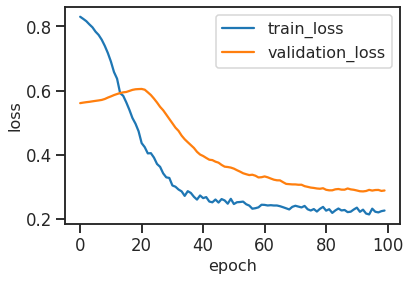

In [4]:
model = keras.Sequential([
layers.Dense(30, activation='swish', input_shape=[X_tr.shape[1]], kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
layers.Dropout(0.2),
layers.Dense(20, activation='swish', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
layers.Dense(15, activation='swish', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
layers.Dense(10, activation='swish', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
layers.Dense(1)
])

# optimizer = tf.keras.optimizers.RMSprop(0.0001)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(loss='mae',
            optimizer=optimizer,
            metrics=['mae'])

EPOCHS = 100
history = model.fit(
  X_tr, Y_tr,
  epochs=EPOCHS, validation_split = 0.2, verbose=0)

plt.plot(np.arange(EPOCHS), history.history['loss'], label = 'train_loss')
plt.plot(np.arange(EPOCHS), history.history['val_loss'], label = 'validation_loss')
plt.legend(fontsize = 16)
plt.xlabel('epoch',fontsize = 16)
plt.ylabel('loss', fontsize = 16)
plt.show()

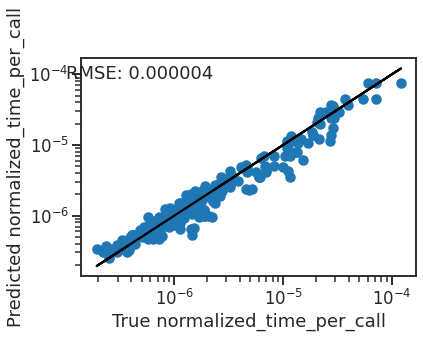

In [6]:
Y_hat = model.predict(X_val)
Y_hats = denormlog(np.array(Y_hat), m_marc[target], s_marc[target])
Y_vals = denormlog(np.array(Y_val.values), m_marc[target], s_marc[target])

plt.scatter(Y_vals, Y_hats)
plt.plot(Y_vals, Y_vals, 'k-')
rmse = mean_squared_error(Y_vals, Y_hats)**0.5
plt.xlabel("True %s" %(target))
plt.ylabel("Predicted %s" %(target))
plt.text(1e-7, 0.7*max((Y_vals)), "RMSE: %.6f" %(rmse))
plt.xscale('log')
plt.yscale('log')
plt.show()

# Validate the model on the chemical dataset

 <ipython-input-1-d16342b28a53>:40: RuntimeWarning:overflow encountered in exp


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

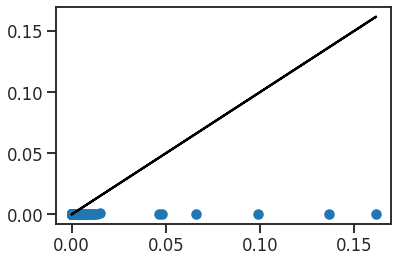

In [8]:
Y_hat_other = model.predict(X_other)
Y_hats_other = denormlog(np.array(Y_hat_other), m_marc[target], s_marc[target])
Y_true_other = denormlog(np.array(Y_other), m_marc[target], s_marc[target])

plt.scatter(Y_true_other, Y_hats_other)
plt.plot(Y_true_other, Y_true_other, 'k-')
rmse = mean_squared_error(Y_true_other, Y_hats_other)**0.5
plt.xlabel("True %s" %(target))
plt.ylabel("Predicted %s" %(target))
plt.text(1e-7, 0.7*max((Y_true_other)), "RMSE: %.6f" %(rmse))
plt.xscale('log')
plt.yscale('log')
plt.show()

# Train models on all data

In [8]:
# df_normlog, m, s = normlog(df_tot.drop(columns = ['n_calls', 'n_lanthanid', 'n_transition', 'n_species', 'n_el', 'n_ks',
#                                                    'convergence', 'n_g_smooth', 'n_at', 'n_betas', 'n_k', 'n_cores']))
df_normlog, m_tpc, s_tpc = normlog(df_tot.drop(columns = ['n_calls', 'convergence'] + elements))

X_tr, Y_tr, X_val, Y_val = train_test_split(df_normlog, split=tv_split, yname = target)

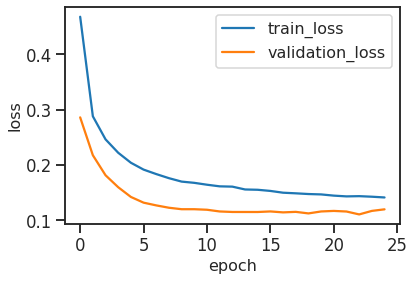

In [10]:
model_tpc = keras.Sequential([
layers.Dense(30, activation='swish', input_shape=[X_tr.drop(columns = 'time_per_call').shape[1]], 
             kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
layers.Dropout(0.2),
layers.Dense(20, activation='swish', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
layers.Dense(15, activation='swish', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
layers.Dense(10, activation='swish', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)

model_tpc.compile(loss='mae',
            optimizer=optimizer,
            metrics=['mae'])

EPOCHS = 25
history = model_tpc.fit(
  X_tr.drop(columns = 'time_per_call'), Y_tr,
  epochs=EPOCHS, validation_split = 0.2, verbose=0)

plt.plot(np.arange(EPOCHS), history.history['loss'], label = 'train_loss')
plt.plot(np.arange(EPOCHS), history.history['val_loss'], label = 'validation_loss')
plt.legend(fontsize = 16)
plt.xlabel('epoch',fontsize = 16)
plt.ylabel('loss', fontsize = 16)
plt.show()

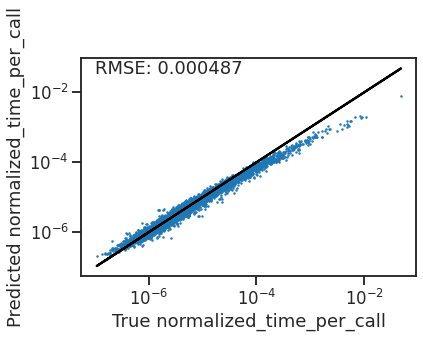

In [11]:
Y_hat = model_tpc.predict(X_val.drop(columns = 'time_per_call'))
Y_hats = denormlog(np.array(Y_hat), m_tpc[target], s_tpc[target])
Y_vals = denormlog(np.array(Y_val), m_tpc[target], s_tpc[target])

plt.scatter(Y_vals, Y_hats, s=1)
plt.plot(Y_vals, Y_vals, 'k-')
rmse = mean_squared_error(Y_vals, Y_hats)**0.5
plt.xlabel("True %s" %(target))
plt.ylabel("Predicted %s" %(target))
plt.text(1e-7, 0.7*max((Y_vals)), "RMSE: %.6f" %(rmse))
plt.xscale('log')
plt.yscale('log')
plt.show()

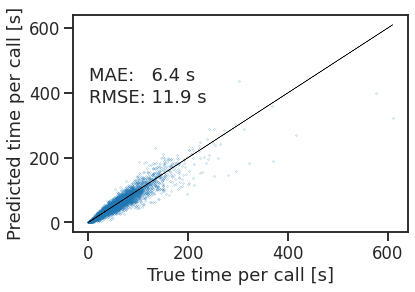

In [13]:
X_val_normlog = denormlog(X_val, m_tpc.drop(target), s_tpc.drop(target))
scaling = X_val_normlog['n_el^3']*X_val_normlog['n_k']/X_val_normlog['n_cores']
yt = Y_vals * scaling
yp = Y_hats[:, 0] * scaling

plt.scatter(yt, yp, s=.05)
plt.plot(yt, yt, 'k-', lw= .5)
rmse = mean_squared_error(yt, yp)**0.5
plt.xlabel("True time per call [s]")
plt.ylabel("Predicted time per call [s]")
plt.text(1, 0.85*max((yp)), "RMSE: %.1f s" %(rmse))
plt.text(1, 1*max((yp)), "MAE:   %.1f s" %(abs(yt - yp).mean()))
plt.show()

# ANN model for number of calls

In [67]:
# df_normlog, m, s = normlog(df_tot.drop(columns = ['n_calls', 'n_lanthanid', 'n_transition', 'n_species', 'n_el', 'n_ks',
#                                                    'convergence', 'n_g_smooth', 'n_at', 'n_betas', 'n_k', 'n_cores']))
df_normlog, m_nc, s_nc = norm(df_tot_el.drop(columns = [target, 'n_cores', 'n_nodes', 'threads_per_node', 'n_pool', 'arch',
                                                       'n_transition', 'n_lanthanid', 'n_el^3', 'time_per_call']))
df_normlog = df_normlog.astype('float32')
X_tr, Y_tr, X_val, Y_val = train_test_split(df_normlog, split=tv_split, yname = 'n_calls')

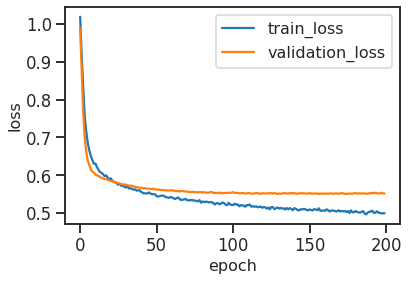

In [68]:
model_nc = keras.Sequential([
layers.Dense(30, activation='swish', input_shape=[X_tr.shape[1]], 
             kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
layers.Dropout(0.2),
layers.Dense(20, activation='swish', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
layers.Dropout(0.2),
layers.Dense(15, activation='swish', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
layers.Dropout(0.2),
layers.Dense(10, activation='swish', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model_nc.compile(loss='mse',
            optimizer=optimizer,
            metrics=['mse'])

EPOCHS = 200
history = model_nc.fit(
  X_tr, Y_tr,
  epochs=EPOCHS, validation_split = 0.2, verbose=0)

plt.plot(np.arange(EPOCHS), history.history['loss'], label = 'train_loss')
plt.plot(np.arange(EPOCHS), history.history['val_loss'], label = 'validation_loss')
plt.legend(fontsize = 16)
plt.xlabel('epoch',fontsize = 16)
plt.ylabel('loss', fontsize = 16)
plt.show()

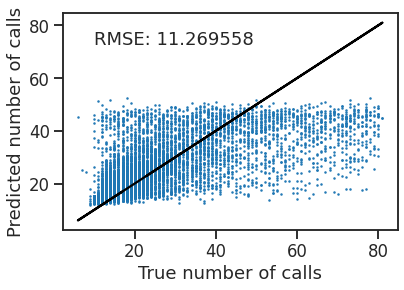

In [69]:
Y_hat = model_nc.predict(X_val)
Y_hats = denorm(np.array(Y_hat), m_nc['n_calls'], s_nc['n_calls'])
Y_vals = denorm(np.array(Y_val), m_nc['n_calls'], s_nc['n_calls'])

plt.scatter(Y_vals, Y_hats, s=1)
plt.plot(Y_vals, Y_vals, 'k-')
rmse = mean_squared_error(Y_vals, Y_hats)**0.5
plt.xlabel("True number of calls")
plt.ylabel("Predicted number of calls")
plt.text(10, 0.9*max((Y_vals)), "RMSE: %.6f" %(rmse))
plt.show()

# Total Time Prediction

In [70]:
X_nc = df_tot_el.drop(columns = [target, 'n_cores', 'n_nodes', 'threads_per_node', 'n_pool', 'arch',
                                                       'n_transition', 'n_lanthanid', 'n_el^3', 'time_per_call', 'n_calls'])
df_normlog_nc, m_nc, s_nc = norm(df_tot_el.drop(columns = [target, 'n_cores', 'n_nodes', 'threads_per_node', 'n_pool', 'arch',
                                                       'n_transition', 'n_lanthanid', 'n_el^3', 'time_per_call']))
X_nc_nl, _, __ = normlog(X_nc.astype('float32'), m_nc.drop('n_calls'), s_nc.drop('n_calls'))


X_tpc = df_tot.drop(columns = [target, 'n_calls', 'convergence'])
df_normlog_tpc, m_tpc, s_tpc = norm(df_tot.drop(columns = ['n_calls', 'convergence']))
X_tpc_nl, _, __ = normlog(X_tpc.astype('float32'), m_tpc.drop(target), s_tpc.drop(target))


Y = df_tot[target]*df_tot['n_el^3']*df_tot['n_k']/df_tot['n_cores']*df_tot['n_calls']

In [66]:
Y_nc = denormlog(model_nc.predict(X_nc_nl), m_nc.n_calls, s_nc.n_calls).reshape(1, -1)[0]
Y_tpc = denormlog(model_tpc.predict(X_tpc_nl.drop(columns = 'time_per_call')), m_tpc[target], s_tpc[target]).reshape(1, -1)[0]
Y_tpc = Y_tpc*X_tpc['n_el^3']*X_tpc['n_k']/X_tpc['n_cores']

Y_hat = Y_nc*Y_tpc
Y_true = df_tot['time_per_call']*df_tot['n_calls']

ValueError: in user code:

    /home/claudio/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1462 predict_function  *
        return step_function(self, iterator)
    /home/claudio/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/claudio/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/claudio/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/claudio/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/claudio/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1445 run_step  **
        outputs = model.predict_step(data)
    /home/claudio/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1418 predict_step
        return self(x, training=False)
    /home/claudio/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    /home/claudio/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:212 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_3 is incompatible with the layer: expected axis -1 of input shape to have value 16 but received input with shape [32, 127]


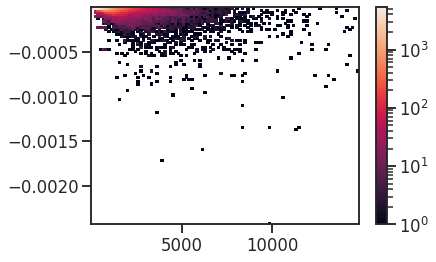

In [61]:
plt.hist2d(Y_true, Y_hat, bins = 100, norm=mpl.colors.LogNorm())
mae = np.mean(abs(Y_true- Y_hat))
rmse = mean_squared_error(Y_true, Y_hat)**0.5
plt.colorbar()
# plt.xlim(0, 15000)
# plt.ylim(0, 15000)
# plt.text(1, 1.15*15000, "RMSE: %.1f s" %(rmse))
# plt.text(1, 1.05*15000, "MAE:   %.1f s" %(mae))
# plt.text(10000, 1.15*15000, "Rel. RMSE: %.1f" %(rmse/np.mean(Y_true)))
# plt.text(10000, 1.05*15000, "Rel. MAE:   %.1f" %(mae/np.mean(Y_true)))
plt.show()

# Total Time prediction direct model

In [62]:
df_time = df_tot.copy()
df_time['time'] = df_time[target]*df_time['n_el^3']*df_time['n_k']/df_time['n_cores']*df_time['n_calls']
df_normlog, m_time, s_time = normlog(df_time.drop(columns = [target, 'n_calls', 'time_per_call']))
X_tr, Y_tr, X_val, Y_val = train_test_split(df_normlog, split=tv_split, yname = 'time')

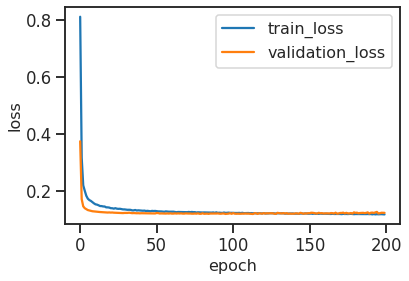

In [63]:
model_all = keras.Sequential([
layers.Dense(30, activation='swish', input_shape=[X_tr.shape[1]], 
             kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
layers.Dropout(0.2),
layers.Dense(20, activation='swish', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
layers.Dense(15, activation='swish', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
layers.Dense(10, activation='swish', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model_all.compile(loss='mse',
            optimizer=optimizer,
            metrics=['mse'])

EPOCHS = 200
history = model_all.fit(
  X_tr, Y_tr,
  epochs=EPOCHS, validation_split = 0.2, verbose=0)

plt.plot(np.arange(EPOCHS), history.history['loss'], label = 'train_loss')
plt.plot(np.arange(EPOCHS), history.history['val_loss'], label = 'validation_loss')
plt.legend(fontsize = 16)
plt.xlabel('epoch',fontsize = 16)
plt.ylabel('loss', fontsize = 16)
plt.show()

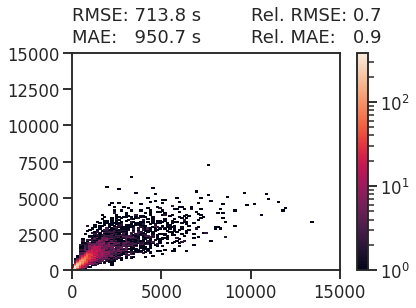

In [64]:
Y_hat = model_all.predict(X_val)
Y_hats = denormlog(np.array(Y_hat), m_time['time'], s_time['time'])
Y_vals = denormlog(np.array(Y_val), m_time['time'], s_time['time'])

mae = np.mean(abs(Y_vals- Y_hats))
rmse = mean_squared_error(Y_vals, Y_hats)**0.5
plt.hist2d(Y_vals, Y_hats[:, 0], bins = 100, norm=mpl.colors.LogNorm())
plt.colorbar()
plt.xlim(0, 15000)
plt.ylim(0, 15000)
plt.text(1, 1.15*15000, "RMSE: %.1f s" %(rmse))
plt.text(1, 1.05*15000, "MAE:   %.1f s" %(mae))
plt.text(10000, 1.15*15000, "Rel. RMSE: %.1f" %(rmse/np.mean(Y_true)))
plt.text(10000, 1.05*15000, "Rel. MAE:   %.1f" %(mae/np.mean(Y_true)))
plt.show()

In [78]:
(df_tot['n_calls']*df_tot.time_per_call).mean()

1085.300756934103